In [1]:
import logging
from binance.futures import Futures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os

In [2]:
#PARAMETERS
TIMEFRAME = "4h"
PAIR = "ETHUSDT"
DATA_WINDOW_LENGTH = 30
ROLLING_WINDOW_LENGTH = 6 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

In [3]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")

In [4]:
%%capture
config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)
# logging.info(futures_client.continuous_klines("BTCUSDT", 'PERPETUAL', '15m', limit=100));
klines = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, limit=DATA_WINDOW_LENGTH);

In [5]:
def process_klines(klines):

    df = pd.DataFrame(klines)
    df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
    df['trades'] = pd.to_numeric(df['trades'])
    df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
    df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
    df['ignore'] = pd.to_numeric(df['ignore'])
    df.drop(['ignore'], axis=1, inplace=True)
    return df

In [6]:
df = process_klines(klines)
df;

In [7]:
closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()

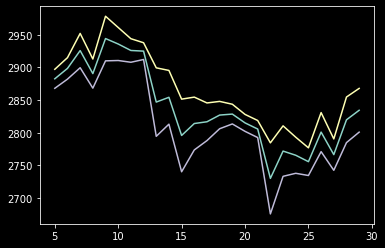

In [8]:
ax1 = plt.axis(); plt.plot(closes_mean)
ax2 = plt.axis(); plt.plot(closes_mean + closes_std)
ax3 = plt.axis(); plt.plot(closes_mean - closes_std)

In [9]:
avg_pdev = (closes_std/closes_mean).mean() # average percentual deviation from the EMA
print(avg_pdev)
callback_rate = round(avg_pdev*100/CALLBACKRATE_FACTOR, ndigits=2)
print(callback_rate)

0.010105909242570113
0.1


In [10]:
print(closes_std.mean())
print(closes_mean.mean())

28.587509282938818
2839.160106788607


In [11]:
avg_pdev = (closes_std/closes_mean).mean()*100 #the callback rate is a tenth of the percentual stdev
avg_pdev

1.0105909242570112

In [12]:
acc_info = futures_client.account();


In [13]:
positions = acc_info["positions"]

def get_open_positions(positions):
    
    open_positions = {}
    for position in positions:
        if float(position["positionAmt"]) != 0.0:
            open_positions[position['symbol']] = {
                # 'direction': position['positionSide'],
                'entry_price': float(position['entryPrice']),
                'upnl': float(position['unrealizedProfit']), 
                'pos_amt': float(position['positionAmt']),
                'leverage': int(position['leverage']),
                }
            print(f"{open_positions[position['symbol']]}")
    return open_positions



In [14]:
open_positions = get_open_positions(positions)

{'entry_price': 214.97, 'upnl': -0.4209, 'pos_amt': 0.305, 'leverage': 10}
{'entry_price': 2.146462068965, 'upnl': -5.76799792, 'pos_amt': 232.0, 'leverage': 30}
{'entry_price': 1.1102, 'upnl': -0.65, 'pos_amt': 65.0, 'leverage': 7}
{'entry_price': 38645.1, 'upnl': -0.015, 'pos_amt': 0.002, 'leverage': 10}
{'entry_price': 3.4532, 'upnl': -0.3482577, 'pos_amt': 10.0, 'leverage': 8}
{'entry_price': 0.7973, 'upnl': -0.896, 'pos_amt': 80.0, 'leverage': 7}


In [32]:

try:
    response = response = futures_client.new_order(symbol=PAIR, side = "SELL", type= "TRAILING_STOP_MARKET", quantity= 0.042, reduceOnly = True, timeInForce="GTC", activationPrice= 2900.00, callbackRate=0.1)
    logging.info(response)
except ClientError as error:
    logging.error(
        "Found error. status: {}, error code: {}, error message: {}".format(
            error.status_code, error.error_code, error.error_message
        )
    )